In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from Codigo import *
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
sns.set(style="whitegrid")

# Modelo A traves del metodo Box Jenkins

In [3]:
datos = Tachos('../Alemania_Reducida.csv')
Columnas(datos, 'Inflación')

Inflación, índice de deflación del PIB (% anual)
Inflación, precios al consumidor (% anual)
Inflación, deflactor del PIB: series vinculadas (% anual)


In [4]:
variable = pd.DataFrame({f'inflacion':datos['Inflación, precios al consumidor (% anual)']})

In [5]:
variable['log'] = np.log(variable['inflacion'])
variable['ldiff'] = variable['log'].diff()
variable['inflacion'] = variable['inflacion']/100
variable['diff'] = variable['inflacion'].diff()
variable.dropna(axis = 0, inplace = True)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Identificacion de la Serie Temporal

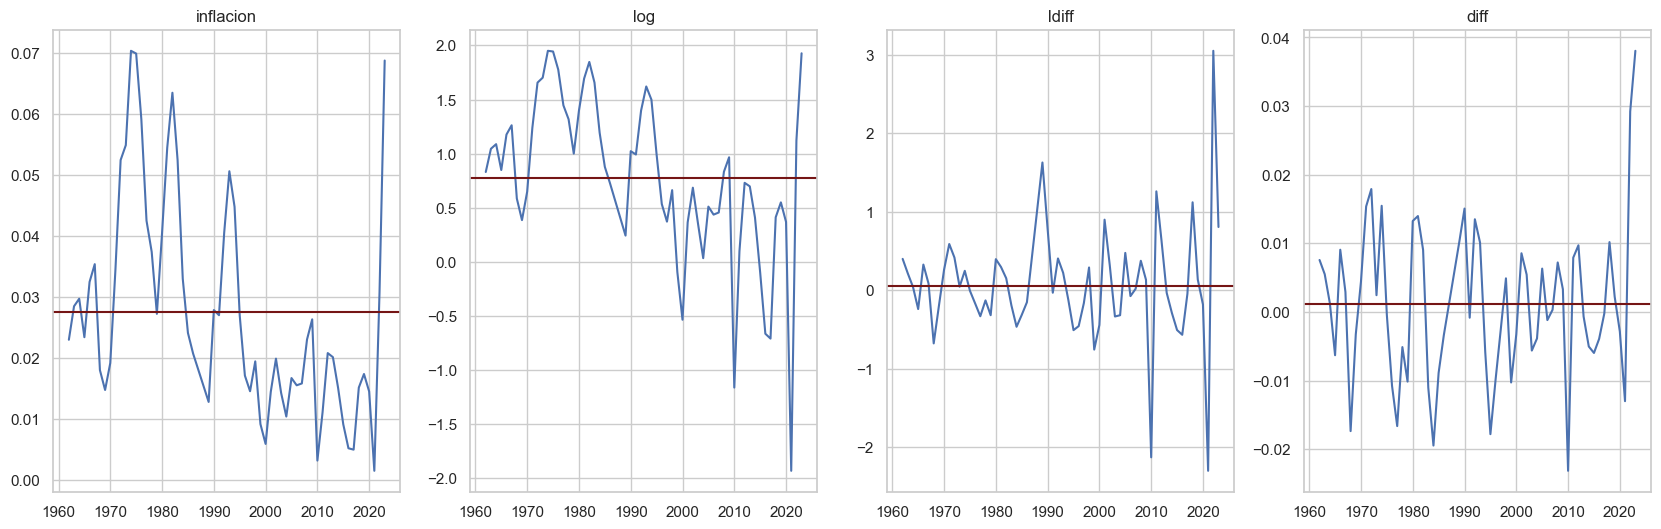

In [6]:
plt.figure(figsize=(26,6))

for i in range(len(variable.columns)):
    a = variable.columns[i]
    plt.subplot(1,len(variable.columns)+1, i+1)
    plt.plot(variable[a])
    plt.title(a)
    plt.axhline(y = variable[a].mean(), c = '#751515')

plt.show()

#### Pruebas de Dickey Fuller de todas las variables para estacionaridad

In [7]:
for i in variable.columns:
    print('==============================================')
    print(i)
    print('===============================================')
    DFuller(variable[i])

inflacion
Estadístico ADF: -3.1247151604033534
Valor p: 0.02477740429950823
Rechazamos la hipótesis nula; la serie es estacionaria.
log
Estadístico ADF: -1.643223504722491
Valor p: 0.4605769188187698
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
ldiff
Estadístico ADF: -2.981590652220671
Valor p: 0.036649734904353116
Rechazamos la hipótesis nula; la serie es estacionaria.
diff
Estadístico ADF: -5.367988229524993
Valor p: 3.95303208525612e-06
Rechazamos la hipótesis nula; la serie es estacionaria.


### Eleccion de los datos
- Se eligio la serie original sin log ni diferencial por que es de mas facil explicacion y su p valor indica que podemos rechazar la hipotesis nula.

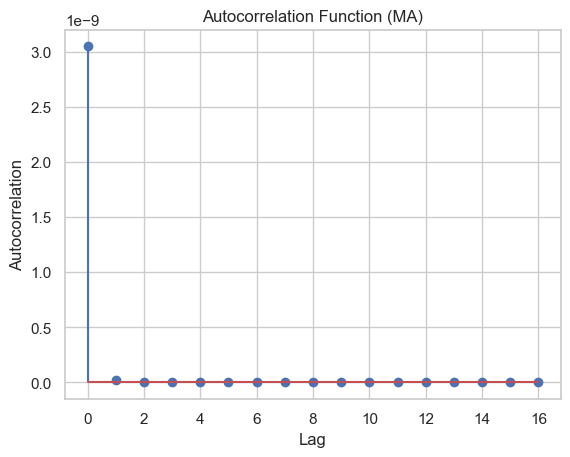

In [8]:
acf_ma(variable['inflacion'],2)

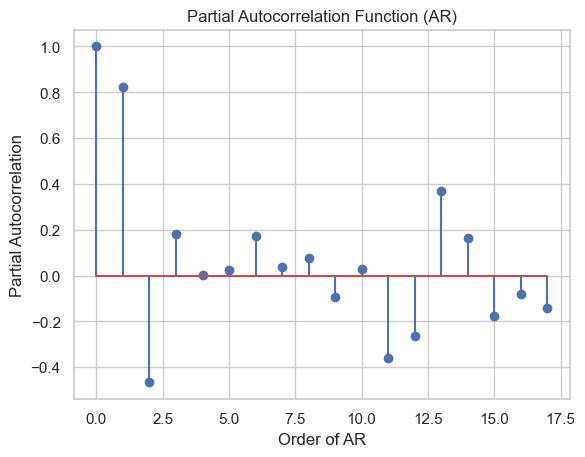

In [9]:
pacf_ar(variable['inflacion'])

- Segun la grafica me dice que deberia optar por un ARMA (3,0) pero probaremos con el sistema que creamos para elegir los valores

In [10]:
Pruebatoolkit(variable['inflacion'],6, p_value= 0.05)
# Este sistema que creamos tiene 2 parametros importantes pero iniciare explicado su formulación.
# Paso uno, itera entre todas las posibilidades hasta llegar a (6,6,6) eleccion que hice por que ocupa un tiempo prudente y el valor es superior a lo que demuestran los graficos.
# Entre ellos busca el AIC o Akaike mas bajo posible tendiendo al -inf, pero con una restriccion importante, tambien ve los p valores de los coeficientes y si tienen 
# mayor al umbral dispuesto no se acepta y pasa al siguiente

Mejor orden encontrado: (1, 0, 1) con AIC: -374.3616186500578


(1, 0, 1)

### Estimación del Modelo.
Ya elegido el modelo se hace una estimacion del modelo con el orden preferido por el sistema iterativo.

In [11]:
model = ARIMA(variable['inflacion'], order = (1,0,1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:              inflacion   No. Observations:                   60
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 191.181
Date:                Tue, 12 Dec 2023   AIC                           -374.362
Time:                        13:19:11   BIC                           -365.984
Sample:                             0   HQIC                          -371.085
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0292      0.006      4.534      0.000       0.017       0.042
ar.L1          0.6774      0.130      5.225      0.000       0.423       0.932
ma.L1          0.4911      0.112      4.376      0.0

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Diagnostico del Modelo

In [24]:
resultado = acorr_ljungbox(variable['inflacion'], lags=4)

for i in range(len(resultado)):
    print(f'rezago Nro {i+1}')
    print('=========================')
    print('Valor estadistico: ',resultado['lb_stat'].iloc[i])
    if resultado['lb_pvalue'].iloc[i]>0.05:
        print("No hay evidencia para rechazar la hipótesis nula de independencia de los rezagos.")
    else:
        print("Se rechaza la hipótesis nula de independencia de los rezagos.")

rezago Nro 1
Valor estadistico:  35.15432296733882
Se rechaza la hipótesis nula de independencia de los rezagos.
rezago Nro 2
Valor estadistico:  49.13135657502864
Se rechaza la hipótesis nula de independencia de los rezagos.
rezago Nro 3
Valor estadistico:  56.13608977695588
Se rechaza la hipótesis nula de independencia de los rezagos.
rezago Nro 4
Valor estadistico:  59.716331038270894
Se rechaza la hipótesis nula de independencia de los rezagos.


- Definí el código para rechazar o aceptar la idependencia de los rezagos con la prueba Ljung-Box, y este nos dice que se rechaza la hipotesis nula por lo que existe independecia de los rezagos, dando a entender que existe correlacion entre ellos. Esto sugiere revisar y ajustar el modelo posiblemente usando alguna de las variables creadas desde la original como puede ser las diferencias.

### Prediccion del Modelo.
Para esto usamos tanto el valor predicho como sus desviaciones maximas con el error para ver el área que ocupan el tiempo que definimos fue el doble de lo que el sistema creado Toolkit dio pero usaremos con fines graficos un poco mas esta vez

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


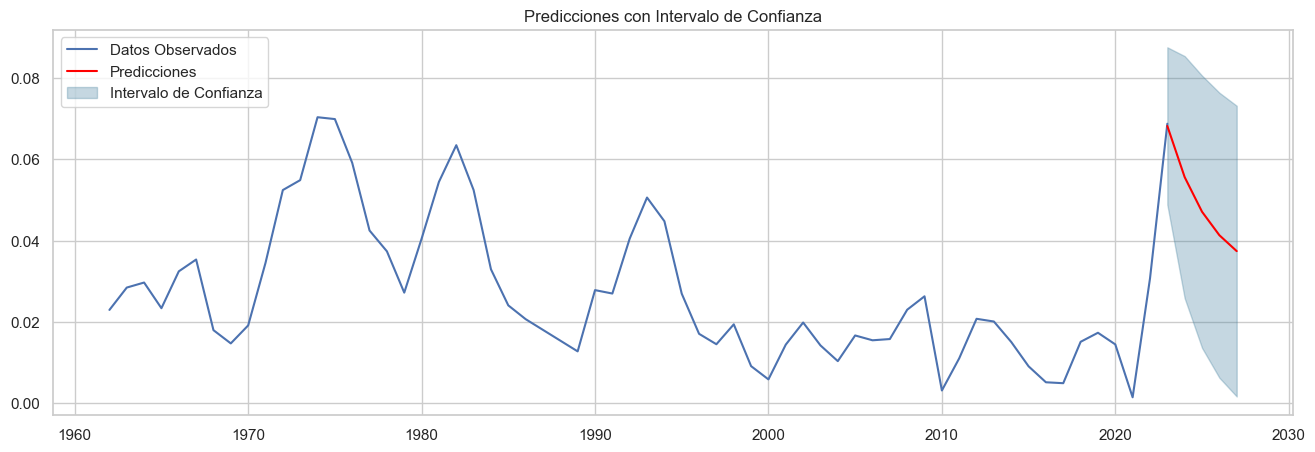

In [12]:
tiempo = 5
prediccion = model.get_forecast(tiempo)
fechas_prediccion = pd.date_range(start=variable.index[-1], periods=tiempo, freq='Y')
intervalo_confianza = prediccion.conf_int()
predicciones_df = pd.DataFrame({'Prediccion': prediccion.predicted_mean.values, 'Lower': intervalo_confianza.iloc[:, 0], 'Upper': intervalo_confianza.iloc[:, 1]}, index=fechas_prediccion)
plt.figure(figsize=(16,5))
plt.plot(variable['inflacion'], label='Datos Observados')
plt.plot(predicciones_df['Prediccion'], color='red', label='Predicciones')
plt.fill_between(predicciones_df.index,intervalo_confianza['lower inflacion'], intervalo_confianza['upper inflacion'], color='#3F7D9C', alpha=0.3, label='Intervalo de Confianza')
plt.title('Predicciones con Intervalo de Confianza')
plt.legend(loc = 'upper left')
plt.show()

- En si la prediccion nos dice que la tasa de inflación en alemania tendera a la baja en los siguientes años, por la fiabilidad estadistica de los datos en este modelo econométrico se podria inferir que se encuenta en lo correcto, pero se deberian revisar otras variables que podrian ayudar a inferir los futuros niveles de inflación como la tasa de referencia de la moneda local, euro, las politicas fiscales del pais y la tendencia exogena de los paises influyentes.